# Pràctica 1: Aprenentatge Supervisat

## 0. Intro
L'objectiu principal d’aquesta pràctica és desenvolupar un sistema capaç de fer prediccions i classificacions sobre un conjunt de dades reals, mitjançant tècniques d’aprenentatge automàtic supervisat.

Es treballarà amb un conjunt de dades que conté informació física i de qualitat sobre més de 50.000 diamants, així com el seu preu. Es disposa de dues particions: un conjunt d'entrenament (`diamonds-train.csv`) que s’utilitzarà per construir i ajustar els models, i un conjunt de test (`diamonds-test.csv`) que servirà per avaluar-ne el rendiment final.

Els objectius específics de la pràctica són:

- Realitzar el pre-processament adequat de les dades.
- Aplicar diferents tècniques de **regressió** per predir el preu dels diamants.
- Aplicar tècniques de **classificació** per predir atributs com la qualitat del tall (`cut`).
- Utilitzar **validació creuada (cross-validation)** per ajustar els hiperparàmetres i evitar sobreajustament.
- Avaluar i comparar el rendiment dels diferents models emprats.

Aquest notebook està estructurat en seccions clares i inclou tant el codi com les explicacions necessàries per entendre cada pas del procés.


## 1. Lectura de les dades

Per començar la pràctica, importem totes les llibreries que farem servir. Utilitzarem eines com `pandas` i `numpy` per tractar dades, `matplotlib` i `seaborn` per visualitzar-les. I per l'aprenentatge supervisat `scikit-learn`.

In [2]:
#Importar llibreries necessàries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, accuracy_score, confusion_matrix, recall_score, roc_curve, auc

Realitzem la lectura dels conjunts d'entrenament i de test.

In [3]:
#Lectura de les dades
df_train = pd.read_csv("diamonds-train.csv")
df_test = pd.read_csv("diamonds-test.csv")

#Comprovar la lectura
print("Dades d'entrenament:")
display(df_train.head())

print("\n Dades de test:")
display(df_test.head())

Dades d'entrenament:


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.53,Very Good,D,VS2,63.2,56.0,5.10,5.15,3.24,1601
1,2,0.32,Premium,H,VS2,62.4,58.0,4.36,4.33,2.71,648
2,3,0.76,Ideal,I,SI1,61.8,57.0,5.89,5.83,3.62,2399
3,4,1.01,Good,H,VS2,60.8,61.0,6.43,6.50,3.93,5229
4,5,0.73,Ideal,I,VS1,62.1,54.0,5.77,5.80,3.59,2167



 Dades de test:


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,44001,1.09,Ideal,G,VVS2,62.5,56.0,6.54,6.58,4.10,8282
1,44002,0.70,Very Good,F,SI1,59.8,60.0,5.75,5.83,3.46,2196
2,44003,2.01,Good,I,SI1,58.8,60.0,8.27,8.19,4.84,16731
3,44004,0.27,Ideal,F,IF,61.8,55.0,4.14,4.21,2.57,760
4,44005,0.54,Premium,D,SI1,62.3,60.0,5.22,5.18,3.24,1715


## 2. Pre-Processament

### A. Identificar els patrons amb dades "no físiques"

És important validar les dades que siguin coherents. En aquest apartat s'identifiquen les **dades "no físiques"**, tant en el conjunt d'entrenament com el de test. S'apliquen les següents condicions:

- Dimensions (x, y, z) i carat <= 0
- Preu no negatiu ni zero
- Els valors de depth i table han d'estar dins del rang específicat [43-79] i [43-95]

In [4]:
def detectar_dades_no_fisiques(df):
    #Condicions
    cond_x = df['x'] <= 0
    cond_y = df['y'] <= 0
    cond_z = df['z'] <= 0
    cond_carat = df['carat'] <= 0
    cond_price = df['price'] <= 0
    cond_depth = (df['depth'] < 43) | (df['depth'] > 79)
    cond_table = (df['table'] < 43) | (df['table'] > 95)
    
    #DataFrame amb les dades no físiques
    df_noFisiques = df[
        cond_x | cond_y | cond_z |
        cond_carat | cond_price |
        cond_depth | cond_table 
    ]
    
    #Per cada atribut contem les anomalies
    count = {
        'x <= 0': cond_x.sum(),
        'y <= 0': cond_y.sum(),
        'z <= 0': cond_z.sum(),
        'carat <= 0': cond_carat.sum(),
        'price <= 0': cond_price.sum(),
        'depth fora de rang': cond_depth.sum(),
        'table fora de rang': cond_table.sum(),
    }

    # Mostrar els resultats
    print("Recompte per atribut:")
    for attr, count in count.items():
        print(f"{attr}: {count}")

    return df_noFisiques

print("\nDataFrame dades no físiques (entrenament): ")
df_noFisiques_train = detectar_dades_no_fisiques(df_train)
display(df_noFisiques_train)

print("\nDataFrame dades no físiques (test): ")
df_noFisiques_test = detectar_dades_no_fisiques(df_test)
display(df_noFisiques_test)


DataFrame dades no físiques (entrenament): 
Recompte per atribut:
x <= 0: 6
y <= 0: 6
z <= 0: 16
carat <= 0: 0
price <= 0: 0
depth fora de rang: 0
table fora de rang: 0


,id,carat,cut,color,clarity,depth,table,x,y,z,price
1577,1578,1.00,Very Good,H,VS2,63.3,53.0,0.00,0.00,0.0,5139
6555,6556,1.12,Premium,G,I1,60.4,59.0,6.71,6.67,0.0,2383
9582,9583,2.80,Good,G,SI2,63.8,58.0,8.90,8.85,0.0,18788
9858,9859,1.56,Ideal,G,VS2,62.2,54.0,0.00,0.00,0.0,12800
11595,11596,1.14,Fair,G,VS1,57.5,67.0,0.00,0.00,0.0,6381
11837,11838,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0,2130
13415,13416,1.15,Ideal,G,VS2,59.2,56.0,6.88,6.83,0.0,5564
14807,14808,1.00,Premium,G,SI2,59.1,59.0,6.55,6.48,0.0,3142
15634,15635,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0,2130
16397,16398,1.01,Premium,H,I1,58.1,59.0,6.66,6.60,0.0,3167



DataFrame dades no físiques (test): 
Recompte per atribut:
x <= 0: 2
y <= 0: 1
z <= 0: 4
carat <= 0: 0
price <= 0: 0
depth fora de rang: 0
table fora de rang: 0


,id,carat,cut,color,clarity,depth,table,x,y,z,price
4205,48206,1.07,Ideal,F,SI2,61.6,56.0,0.00,6.62,0.0,4954
8430,52431,1.20,Premium,D,VVS1,62.1,59.0,0.00,0.00,0.0,15686
9202,53203,2.20,Premium,H,SI1,61.2,59.0,8.42,8.37,0.0,17265
9931,53932,2.18,Premium,H,SI2,59.4,61.0,8.49,8.45,0.0,12631


Veiem que tenim **16 files** en el conjunt d'entrenament, i **4 files** en el de test que no tenen sentit físicament **en qüestió de dimensions (x, y, z)**.

### B) Identificar outliers a partir de la distribució de cada atribut

El següent pas és identificar valors atípics que poden afectar el rendiment dels models. Podem detectar-los, utilitzant el mètode de **l'interval interquartílic (IQR)**:
$$
    [Q1 - 1.5 \cdot IQR,\; Q3 + 1.5 \cdot IQR]
$$

Defineix com outlier qualsevol punt que queda fora del **límit inferior** i el **límit superior**.

On Q1 i Q3 són el primer i tercer quartil, respectivament. Un cop identificats, caldrà decidir si s'han d'eliminar, transformar o conservar.

És important destacar que els límits del conjunt d'entrenament també s'apliquen al conjunt de test, per evitar "filtrar" informació. 

In [5]:
#Atributs numèrics
atributs = ['price', 'carat', 'x', 'y', 'z', 'depth', 'table']

#Funció per detectar outliers
def detectar_outliers(df, atributs):
    outliers_iqr = pd.DataFrame()
    
    for col in atributs:
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_iqr = pd.concat([outliers_iqr, outliers])

        print(f"Outliers detectats a '{col}': {len(outliers)}")
        
    #Eliminar duplicats
    outliers_iqr = outliers_iqr.drop_duplicates()
    return outliers_iqr

print("Outliers conjunt entrenament\n")
outliers_train = detectar_outliers(df_train, atributs)
print("\nOutliers conjunt test\n")
outliers_test = detectar_outliers(df_test, atributs)

Outliers conjunt entrenament

Outliers detectats a 'price': 2907
Outliers detectats a 'carat': 1536
Outliers detectats a 'x': 27
Outliers detectats a 'y': 28
Outliers detectats a 'z': 41
Outliers detectats a 'depth': 2063
Outliers detectats a 'table': 490

Outliers conjunt test

Outliers detectats a 'price': 654
Outliers detectats a 'carat': 353
Outliers detectats a 'x': 5
Outliers detectats a 'y': 3
Outliers detectats a 'z': 8
Outliers detectats a 'depth': 482
Outliers detectats a 'table': 115


### C) Identificar outliers a partir de scatter plots atribut/preu

En aquest apartat, utilitzarem **scatter plots** per identificar outliers en funció de la relació entre els atributs físics dels diamants i el seu preu. Els gràfics permetran veure si hi ha punts que es desvien significativament de la tendència general, i ens ajudaran a detectar outliers.


Visualització outliers conjunt d'Entrenament



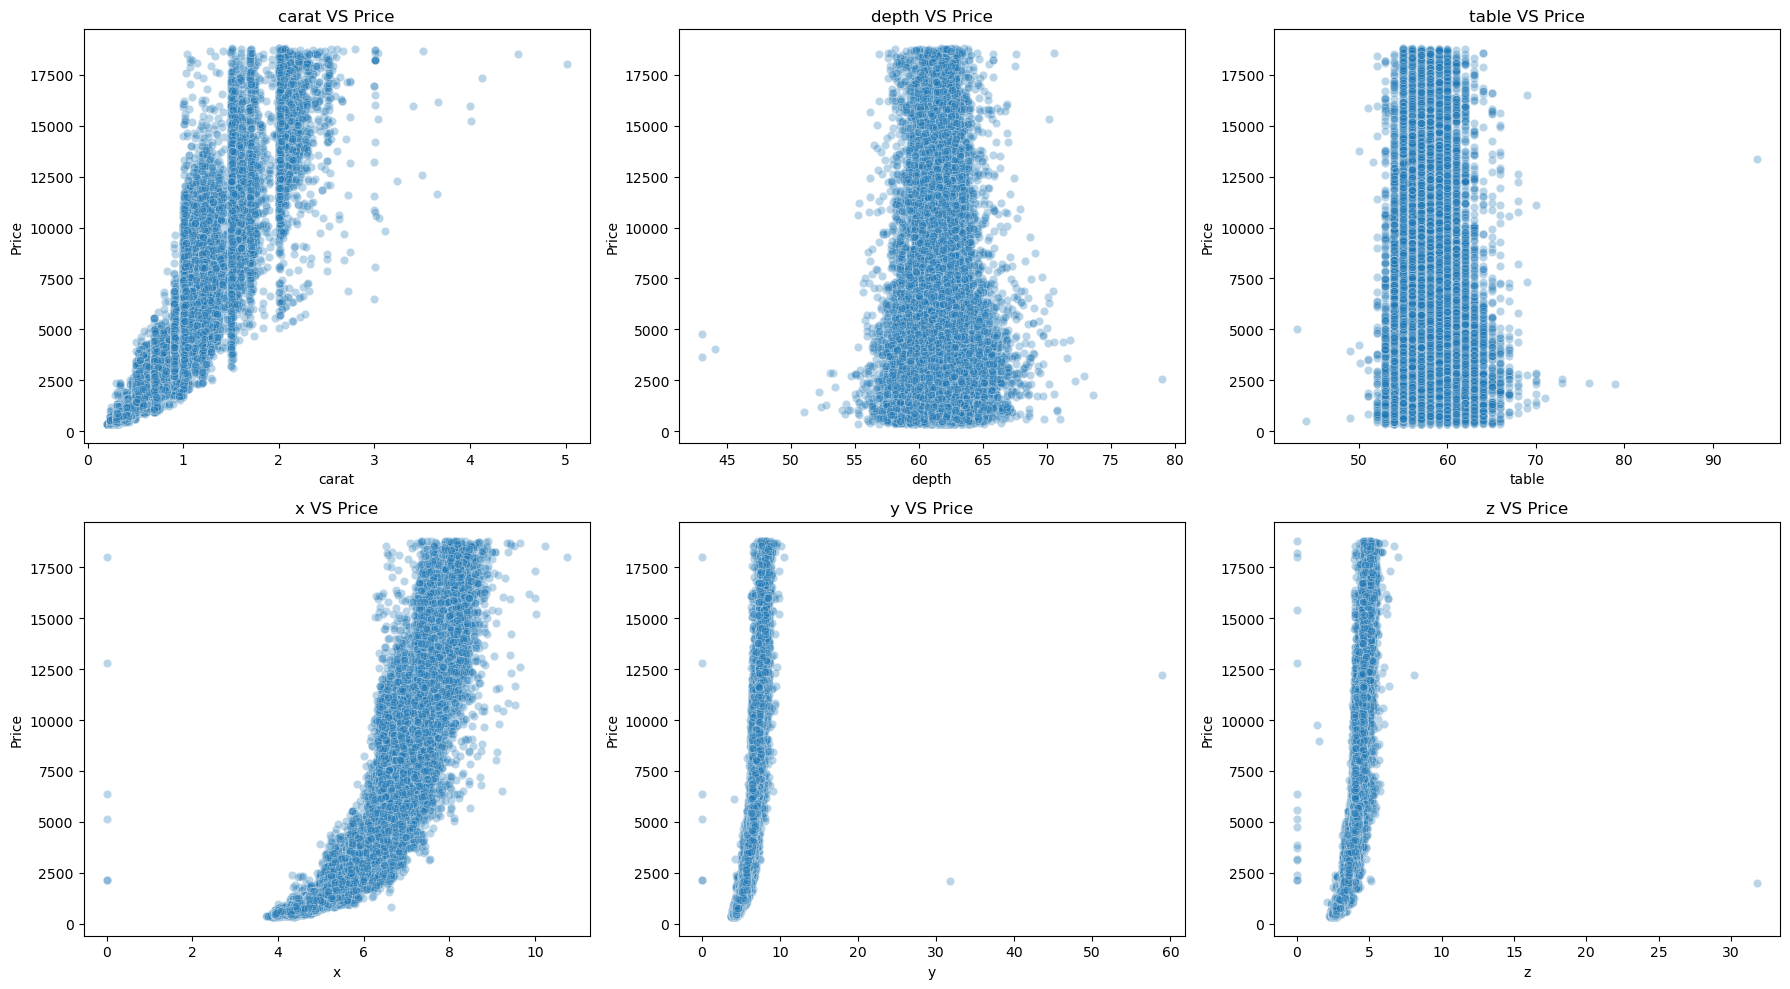


Visualització outliers conjunt de Test



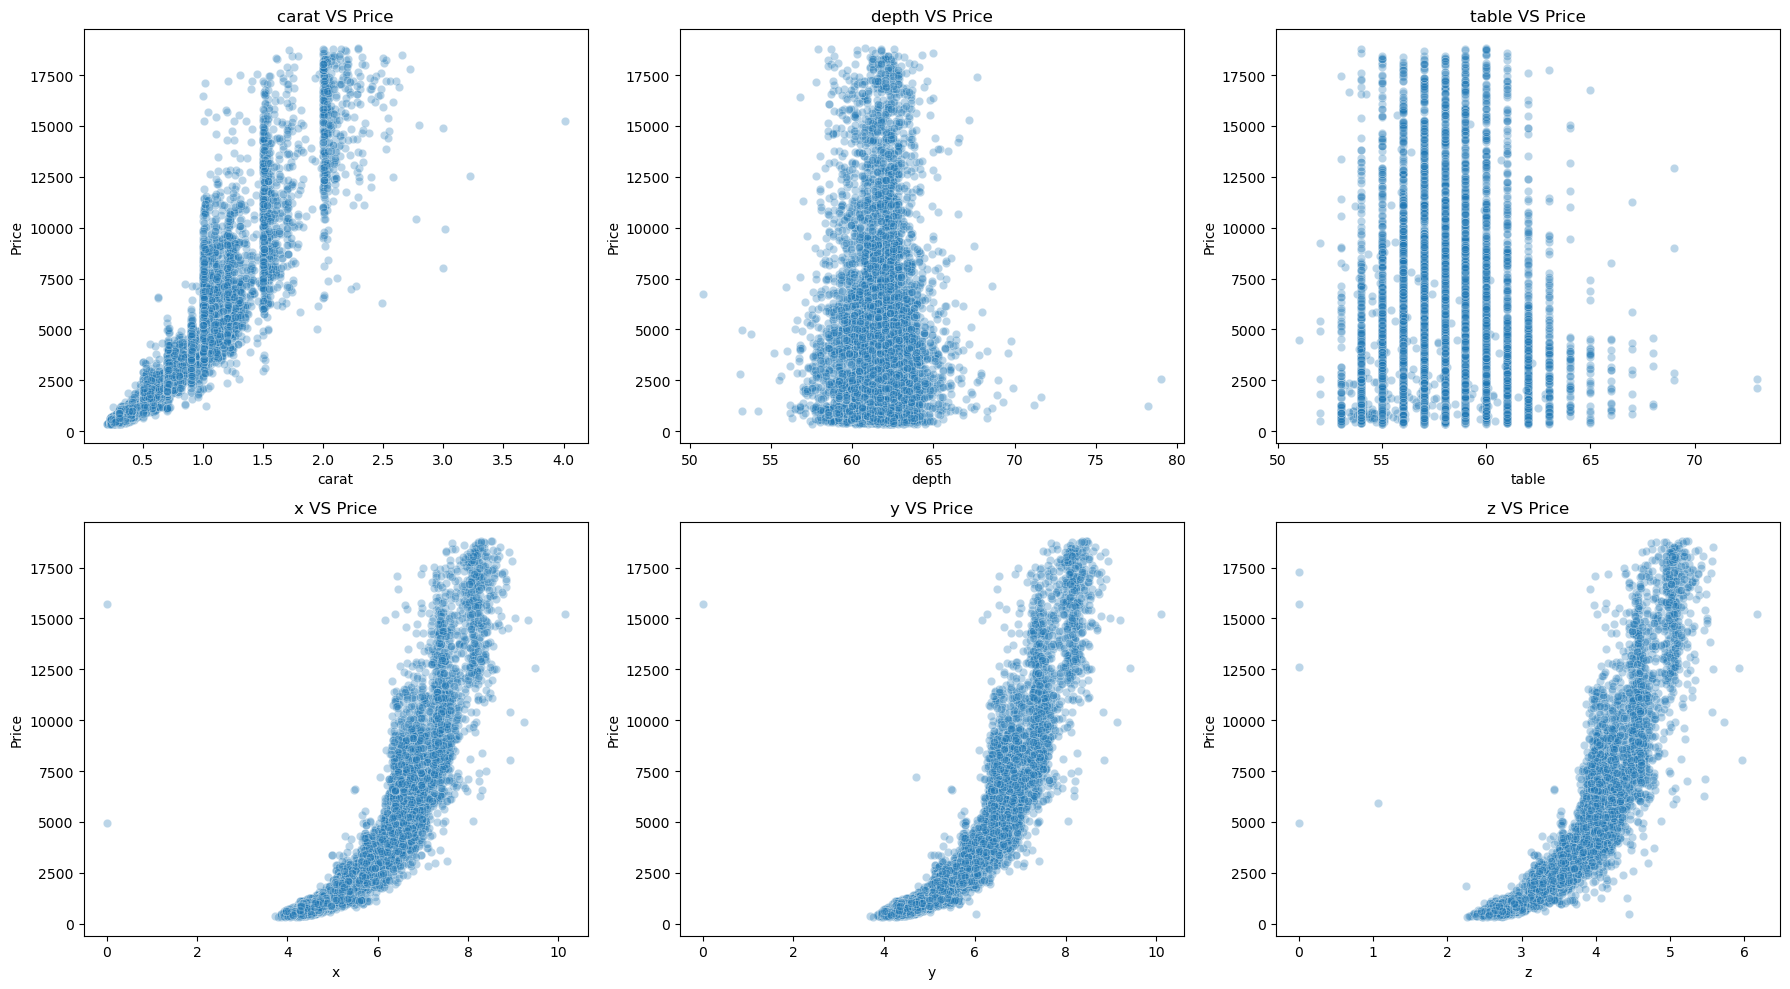

In [6]:
#Atributs numèrics
cols = ['carat', 'depth', 'table', 'x', 'y', 'z']

print("\nVisualització outliers conjunt d'Entrenament\n")

#Figura 2x3
fig, axs = plt.subplots(2, 3, figsize=(18,10))

for i, col in enumerate(cols):
    ax = axs[i // 3][i % 3]
    sns.scatterplot(data=df_train, x=col, y='price', ax=ax, alpha=0.3)
    ax.set_title(f'{col} VS Price')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

print("\nVisualització outliers conjunt de Test\n")

#Figura 2x3
fig, axs = plt.subplots(2, 3, figsize=(18,10))

for i, col in enumerate(cols):
    ax = axs[i // 3][i % 3]
    sns.scatterplot(data=df_test, x=col, y='price', ax=ax, alpha=0.3)
    ax.set_title(f'{col} VS Price')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

Després de representar la relació entre els atributs físics i el preu, s'observa el següent, tant per el **conjunt de d'entrenament**:

- `carat` vs `price`: S'observa una tendència clara, a major carat, major preu, com era d'esperar. Però hi ha diamants amb valors elevats de `carat` amb preus baixos, cosa que pot indicar errors.
- `depth` vs `price`: La dispersió és elevada, la majoria de punts estàn en el rang [60-65], però s'observen punts allunyats que podrien ser outliers.
- `table` vs `price`: Es detecta una forta concentració al voltant del rang [55-65], però s'observen punt molt allunyats que poden distorsionar els models.
- `x`, `y`, `z`: La dispersió és menor que en els altres atribusts, però s'observen punts clarament allunyats. Aquests són outliers molt greus, però sabem que són les dades "no físiques" vistes anteriorment.

En el conjunt de test, encara que no s'hauria d'intervenir ni modificar les dades s'observa el següent:

- La relació `table` vs `price` mostra més dispersió que en l'entrenament.
- Les relacion `y` i `z`vs `price` també presenten un patró diferent respecte l'entrenament. 

### D) Fer una taula amb els identificadors dels outliers, els seus atributs, i les raons per la qual cadascú es considera outlier

Utlitzant el mateix **mètode de l'apartat B**, fem una taula amb els identificadors dels outliers, els atributs en què es troben i les raons per les quals es consideren outliers.

In [7]:
def taula_raons_outliers(df):
    # Diccionari per outliers i raó
    outliers_dict = {}

    # Iterem per cada atribut numèric
    atributs_numerics = ['price', 'carat', 'x', 'y', 'z', 'depth', 'table']

    # Detecció d'outliers (usant IQR)
    for col in atributs_numerics:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Trobat outliers columna actual
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Afegir a la llista de resultats
        for index, row in outliers.iterrows():
            if index not in outliers_dict:
                outliers_dict[index] = {'id': index, 'attributes': {}, 'values': {}}

            # Preparem la raó
            reasons = []
            if row[col] < lower_bound:
                reasons.append(f'{col} < {lower_bound:.2f}')
            if row[col] > upper_bound:
                reasons.append(f'{col} > {upper_bound:.2f}')

            # Afegir el resultat a la llista
            outliers_dict[index]['attributes'][col] = "; ".join(reasons)
            outliers_dict[index]['values'][col] = row[col]

        #Llista DataFrame final
        data = []
        for idx, info in outliers_dict.items():
            data.append({
                'id': info['id'],
                'outliers_attributes': ", ".join(info['attributes'].keys()),
                'outliers_reasons': "; ".join(info['attributes'].values()),
                'values': ", ".join(f"{k}: {v}" for k, v in info['values'].items())
            })

        return pd.DataFrame(data)


outliers_reason_train = taula_raons_outliers(df_train)
# Mostrar la taula
display(outliers_reason_train.head())

,id,outliers_attributes,outliers_reasons,values
0,9,price,price > 11857.12,price: 16340
1,78,price,price > 11857.12,price: 17569
2,83,price,price > 11857.12,price: 13395
3,111,price,price > 11857.12,price: 15197
4,115,price,price > 11857.12,price: 15229


Aquesta taula mostra les raons per les quals cada punt es considera un outlier, i ajuda a identificar possibles valors que podrien distorsionar els models predictius. 

### E) Decidir què fer amb els outliers i aplicar-ho als conjunts de dades.

Ja hem identificat els outliers, ara cal decidir com gestionar-los. Aquesta decisió clau pot afectar al rendiment dels models. Tenim les següents opcions:

- **Eliminar outliers tant en conjunt d'entrenament com test**: Això implicaria eliminar dades del conjunt de test, per tant no és viable.
- **Eliminar outliers en el conjunt d'entrenament**: Evita que distorsionin l'aprenentatge i manté el test intacte. Però com hem vist que el conjunt de test té outliers podria ser que els models no siguin tant eficients.
- **Tractar els outliers**: Podriem aplicar transformacions o limitar-los. Manté la informació però redueix l'impacte dels valors extrems. També és més complex i cal escollir bé com tractar-los.

Nosaltres hem optat per **eliminar les dades "no físiques"** tant al conjunt **d'entrenament com el de test**, i **eliminar els outliers** del conjunt **d'entrenament**. Això evita que els outliers distorsionin l'aprenentatge dels models i manté realista el conjunt de test.

In [8]:
#Eliminació d'outliers físics i estadístics
df_train_cleaned = df_train[~df_train['id'].isin(df_noFisiques_train['id'])]
df_train_cleaned = df_train_cleaned[~df_train_cleaned['id'].isin(outliers_train['id'])]

#Eliminació d'outliers físics conjunt test
df_test_cleaned = df_test[~df_test['id'].isin(df_noFisiques_test['id'])]

print("\n--- Conjunt d'entrenament ---")
print(f"Nombre de registres abans: {len(df_train)}")
print(f"Nombre de registres després de netejar: {len(df_train_cleaned)}")
print(f"Registres eliminats: {len(df_train) - len(df_train_cleaned)}")

print("\n--- Conjunt de test ---")
print(f"Nombre de registres abans: {len(df_test)}")
print(f"Nombre de registres després de netejar: {len(df_test_cleaned)}")
print(f"Registres eliminats: {len(df_test) - len(df_test_cleaned)}")


--- Conjunt d'entrenament ---
Nombre de registres abans: 44000
Nombre de registres després de netejar: 38753
Registres eliminats: 5247

--- Conjunt de test ---
Nombre de registres abans: 9940
Nombre de registres després de netejar: 9936
Registres eliminats: 4


### F) Convertir els atributs categòrics en numèrics. 

Els atributs `cut`, `color` i `clarity` són variables categòriques amb un ordre semàntic clar. Per tal de preservar aquesta informació i facilitar l'entrenament dels models, s'han **transformat en valors numèrics** utilitzant el següent criteri:

- `cut`: Fair (1) < Good (2) < Very Good (3) < Premium (4) < Ideal (5)
- `color`: J (1) < I (2) < H (3) < G (4) < F (5) < E (6) < D (7)
- `clarity`: I1 (1) < SI2 (2) < SI1 (3) < VS2 (4) < VS1 (5) < VVS2 (6) < VVS1 (7) < IF (8)

És essencial aplicar **exactament la mateixa codificació** al conjunt de test per assegurar que les dades tenen la mateixa representació numèrica, ja que el model no pot treballar amb categories desconegudes o codificacions diferents.

Aquesta codificació ordinal permet als models captar millor la relació entre qualitat i preu.

In [8]:
#Treballem amb una còpia dels DataFrame
df_train_cleaned = df_train_cleaned.copy()
df_test_cleaned = df_test_cleaned.copy()

#Codificació ordinal per els atributs categòrics
ordre_cut = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
ordre_color = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
ordre_clarity = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

#Conversió
df_train_cleaned['cut'] = df_train_cleaned['cut'].map(ordre_cut)
df_train_cleaned['color'] = df_train_cleaned['color'].map(ordre_color)
df_train_cleaned['clarity'] = df_train_cleaned['clarity'].map(ordre_clarity)

df_test_cleaned['cut'] = df_test_cleaned['cut'].map(ordre_cut)
df_test_cleaned['color'] = df_test_cleaned['color'].map(ordre_color)
df_test_cleaned['clarity'] = df_test_cleaned['clarity'].map(ordre_clarity)

#Mostrem
display(df_train_cleaned[['cut', 'color', 'clarity']].head())
display(df_test_cleaned[['cut', 'color', 'clarity']].head())

,cut,color,clarity
0,3,7,4
1,4,3,4
2,5,2,3
3,2,3,4
4,5,2,5


,cut,color,clarity
0,5,4,6
1,3,5,3
2,2,2,3
3,5,5,8
4,4,7,3


### G) Estandaritzar tots els atributs per separat, excepte x, y, z i price

Per tal de garantir que els atributs utilitzats pels models tinguin una escala comparable, s'ha aplicat una **estandardització**, una transformació de cada atribut perquè tingui **mitjana 0** i **desviació estàndard 1**. Això facilita la convergència i la interpretació en molts algoritmes d'aprenentatge automàtic. Els atributs estandaritzats:

- `carat`, `depth`, `table`, `cut`, `color`, `clarity`

Els atributs `x`, `y`, `z` i `price` no s’han estandarditzat, ja que representen mesures físiques absolutes o són la variable objectiu.

Per evitar **data leakage**, la transformació s'ha ajustat **(fit)** únicament sobre el conjunt d'entrenament, i s'ha aplicat **(transform)** sobre el conjunt de test amb els mateixos paràmetres.

In [9]:
#Atributs per estandaritzar per separat
atributs_estandaritzar = ['carat', 'depth', 'table', 'cut', 'color', 'clarity']
df_train_cleaned = df_train_cleaned.copy()
df_test_cleaned = df_test_cleaned.copy()

#Estandaritzar atributs
scaler = StandardScaler()
df_train_cleaned[atributs_estandaritzar] = scaler.fit_transform(df_train_cleaned[atributs_estandaritzar])
df_test_cleaned[atributs_estandaritzar] = scaler.transform(df_test_cleaned[atributs_estandaritzar])

print("Conjunt Entrenament\n")
display(df_train_cleaned[atributs_estandaritzar].describe())

print("\nConjunt Test\n")
display(df_test_cleaned[atributs_estandaritzar].describe())

Conjunt Entrenament



,carat,depth,table,cut,color,clarity
count,3.875300e+04,3.875300e+04,3.875300e+04,3.875300e+04,3.875300e+04,3.875300e+04
mean,-3.373671e-17,2.021636e-15,-1.177484e-15,3.138981e-16,2.145215e-16,1.617162e-16
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.372777e+00,-2.701432e+00,-2.603511e+00,-2.960402e+00,-2.057333e+00,-1.901221e+00
25%,-8.866074e-01,-6.215053e-01,-6.217465e-01,-9.990991e-01,-8.701563e-01,-6.862142e-01
50%,-2.924004e-01,1.019476e-01,-1.263053e-01,-1.844748e-02,-2.765678e-01,-7.871068e-02
75%,8.149854e-01,6.445373e-01,8.645770e-01,9.622042e-01,9.106091e-01,5.287928e-01
max,3.488917e+00,2.634033e+00,3.094062e+00,9.622042e-01,1.504197e+00,2.351303e+00



Conjunt Test



,carat,depth,table,cut,color,clarity
count,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000
mean,0.241764,-0.040326,0.116598,-0.116552,-0.043159,-0.058106
std,1.283480,1.303858,1.111051,1.088863,1.008899,0.993849
min,-1.372777,-9.935962,-3.098952,-2.960402,-2.057333,-1.901221
25%,-0.832589,-0.711937,-0.621747,-0.999099,-0.870156,-0.686214
50%,-0.022306,0.011516,-0.126305,-0.018447,-0.276568,-0.078711
75%,0.923023,0.644537,0.864577,0.962204,0.910609,0.528793
max,8.917808,15.565754,7.800754,0.962204,1.504197,2.351303


### H) Escala x, y i z entre -1 i 1, però de forma conjunta, no cada atribut per separat, min(x, y, z) --> -1, max(x, y, z) --> 1.

Les variables `x`, `y` i `z` representen dimensions físiques del diamant i s'ha escalat conjuntament per mantenir la seva relació relativa. S'ha aplicat un **escalat mínim-màxim de forma global**, on el valor més petit entre tots els `x`, `y` i `z` es mapeja a -1 i el valor més gran a 1.

La fòrmula utilitzada ha estat:

$$
    x_{\text{scaled}} = 2 \cdot \frac{x - \text{min}}{\text{max} - \text{min}} - 1
$$

Aquesta transformació permet mantenir la proporcionalitat original de les tres dimensions però en una escala comuna.

In [10]:
# Trobar mínim i màxim globals de l'entrenament per les variables x, y, z
xyz_train = pd.concat([df_train_cleaned['x'], df_train_cleaned['y'], df_train_cleaned['z']])

min_global = xyz_train.min()
max_global = xyz_train.max()

# Funció per escalar entre -1 i 1 de forma conjunta
def escalar_conjunt(df, min_val, max_val):
    return 2 * (df[['x', 'y', 'z']] - min_val) / (max_val - min_val) - 1

# Aplicar escalat
df_train_cleaned[['x', 'y', 'z']] = escalar_conjunt(df_train_cleaned, min_global, max_global)
df_test_cleaned[['x', 'y', 'z']] = escalar_conjunt(df_test_cleaned, min_global, max_global)

# Comprovar el rang de les dades després de l'escalat
print("Conjunt Entrenament:")
print(df_train_cleaned[['x', 'y', 'z']].min().min(), df_train_cleaned[['x', 'y', 'z']].max().max())
print("\nConjunt Test:")
print(df_test_cleaned[['x', 'y', 'z']].min().min(), df_test_cleaned[['x', 'y', 'z']].max().max())


Conjunt Entrenament:
-1.0 1.0

Conjunt Test:
-1.098981077147016 1.5414847161572056


El conjunt de test pot contenir valors més petits que el mínim o el màxim de l'entrenament. Això és normal i esperat, ja que estem aplicant un escalat basat en els paràmetres de l'entrenament per **evitar data leakage**. 

### I) Calcula el logaritme dels preus, guardar-ho en un nou atribut log_price, i aplicaro lineal entre 0.1 i 0.9

Per normalitzar millor la variable `price`, s'ha calculat el logaritme natural dels preus i s'ha creat una nova columna 'log_price'. Això ajuda a **reduir l'asimetria** de la distribució de preus.

A continuació, s’ha aplicat un escalat lineal a la nova columna `log_price` per ajustar els seus valors al rang [0.1, 0.9] amb la següent fórmula:

$$
    \text{log\_price\_scaled} = 0.8 \cdot \frac{\text{log\_price} - \text{min}}{\text{max} - \text{min}} + 0.1
$$

Aquest procés facilita l'ús del preu com a variable objectiu (target) per a models de predicció.

In [11]:
# Calcular el logaritme del preu
df_train_cleaned['log_price'] = np.log(df_train_cleaned['price'])
df_test_cleaned['log_price'] = np.log(df_test_cleaned['price'])

#Trobar el mínim i màxim del logaritme del preu
min_log = df_train_cleaned['log_price'].min()
max_log = df_train_cleaned['log_price'].max()

#Escalat lineal entre 0.1 i 0.9
def escalar_log(df, min_val, max_val):
    return 0.1 + (df['log_price'] - min_val) * (0.8 / (max_val - min_val))

#Aplicar escalat
df_train_cleaned['log_price'] = escalar_log(df_train_cleaned, min_log, max_log)
df_test_cleaned['log_price'] = escalar_log(df_test_cleaned, min_log, max_log)

# Comprovar el rang del logaritme escalat
print("Conjunt Entrenament:")
print(df_train_cleaned['log_price'].min(), df_train_cleaned['log_price'].max())
print("Conjunt Test:")
print(df_test_cleaned['log_price'].min(), df_test_cleaned['log_price'].max())

Conjunt Entrenament:
0.1 0.9
Conjunt Test:
0.10539692591089507 1.0029015201391474


### J) Construir un nou atribut high_price que valgui 0 si el preu està estrictament per sota dels $2,500 i 1 en cas contrari.

Per classificar els diamants en "molt cars" i "no tan cars", s'ha creat un nou atribut `high_price`. Aquest atribut pren els següents valors:

- **0** si el preu del diamant és inferior a $2,500
  
- **1** si el preu és igual o superior a $2,500

Aquesta variable serà útil per a la **classificació dels diamants** segons el seu preu.

In [12]:
df_train_cleaned['high_price'] = np.where(df_train_cleaned['price'] >= 2500, 1, 0)
print(df_train_cleaned['high_price'].value_counts())

df_test_cleaned['high_price'] = np.where(df_test_cleaned['price'] >= 2500, 1, 0)
print(df_test_cleaned['high_price'].value_counts())

high_price
0    21540
1    17213
Name: count, dtype: int64
high_price
0    5106
1    4830
Name: count, dtype: int64


In [13]:
#Dataset Pre-Processat
display(df_train_cleaned)
display(df_test_cleaned)

,id,carat,cut,color,clarity,depth,table,x,y,z,price,log_price,high_price
0,1,-0.481466,-0.999099,1.504197,-0.078711,1.277559,-0.621747,0.074236,0.088792,-0.467249,1601,0.454284,0
1,2,-1.048664,-0.018447,-0.870156,-0.078711,0.554106,0.369136,-0.141194,-0.149927,-0.621543,648,0.252933,0
2,3,0.139750,0.962204,-1.463745,-0.686214,0.011516,-0.126305,0.304221,0.286754,-0.356623,2399,0.544314,0
3,4,0.814985,-1.979751,-0.870156,-0.078711,-0.892800,1.855459,0.461426,0.481805,-0.266376,5229,0.717766,1
4,5,0.058722,0.962204,-1.463745,0.528793,0.282811,-1.612629,0.269287,0.278020,-0.365357,2167,0.521673,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43994,43995,-1.021654,-0.018447,-1.463745,1.136296,-0.711937,0.864577,-0.117904,-0.126638,-0.624454,743,0.283388,0
43995,43996,0.544891,-0.999099,-0.276568,0.528793,-0.802369,-1.612629,0.414847,0.446870,-0.289665,4590,0.688751,1
43996,43997,-1.075673,-0.018447,1.504197,0.528793,-1.977979,0.369136,-0.126638,-0.135371,-0.647744,877,0.320299,0
43997,43998,-0.832589,-1.979751,-1.463745,-0.686214,1.910580,-0.126305,-0.042213,-0.053857,-0.540029,765,0.289883,0


,id,carat,cut,color,clarity,depth,table,x,y,z,price,log_price,high_price
0,44001,1.031061,0.962204,-0.276568,1.136296,0.644537,-0.621747,0.493450,0.505095,-0.216885,8282,0.820138,1
1,44002,-0.022306,-0.999099,0.317021,-0.686214,-1.797116,1.360018,0.263464,0.286754,-0.403202,2196,0.524632,0
2,44003,3.515926,-1.979751,-1.463745,-0.686214,-2.701432,1.360018,0.997089,0.973799,-0.001456,16731,0.976674,1
3,44004,-1.183711,0.962204,0.317021,2.351303,0.011516,-1.117188,-0.205240,-0.184862,-0.662300,760,0.288424,0
4,44005,-0.454457,-0.018447,1.504197,-0.686214,0.463674,1.360018,0.109170,0.097525,-0.467249,1715,0.469597,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,53936,5.190510,0.962204,-2.057333,-1.293718,0.282811,-0.126305,1.160116,1.174672,0.190684,16914,0.979096,1
9936,53937,1.058070,0.962204,0.317021,1.136296,-0.531074,-0.621747,0.534207,0.525473,-0.222707,9817,0.857989,1
9937,53938,4.164152,0.962204,-1.463745,-1.293718,-0.983232,-0.621747,1.075691,1.064047,0.094614,11104,0.885413,1
9938,53939,0.841995,-0.999099,0.910609,2.351303,1.548853,0.369136,0.461426,0.432314,-0.231441,10710,0.877370,1


## 3. Predicció del preu

L'objectiu d'aquest apartat és predir el preu dels diamants mitjançant tres mètodes de regressió:
- **Regressió Lineal Múltiple (MLR)**
- **k-Nearest Neighbors (k-NN)**
- **Multilayer Neural Network amb Back-Propagation**

El conjunt de dades d'entrenament es dividirà en subconjunts d'entrenament i validació mitjançant cross-validation per ajustar els hiperparàmetres dels models. Un cop ajustats, s'avaluarà la qualitat de la predicció mitjançant mètriques de rendiment.

### Selecció de variables i de la mètrica d'avaluació

En aquest apartat es defineixen les variables independents (inputs) i la variable dependent (target), que en aquest cas és el logaritme del preu del diamants.

S'han exclòs del conjunt el `id`, `price`, `log_price` i `high_price`perquè no són informatives ni rellevants per l'entrenament.

La mètrica d'avaluació principal per mesurar la qualitat de les prediccions és la **MAPE (Mean Absolute Percentage Error)** que expressa l'error relatiu mitjà entre les prediccions i els valors reals en forma percentual.

In [14]:
#Variables independents
X_train = df_train_cleaned.drop(columns=['id', 'price', 'log_price', 'high_price'])

#Variable dependent (target): el logaritme escalat del preu
Y_train = df_train_cleaned['log_price']

X_test = df_test_cleaned.drop(columns=['id', 'price', 'log_price', 'high_price'])

#Variable dependent (target): el logaritme escalat del preu
Y_test = df_test_cleaned['log_price']

#Funció per desescalar
def desescalar_y(y_scaled):
    log_price = ((y_scaled - 0.1) * (max_log - min_log) / 0.8) + min_log
    return np.exp(log_price)


# Definir la mètrica de avaluació (MAPE)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

### Regressió Lineal Múltiple (MLR)

En aquest apartat implementem un model de **regressió lineal múltiple** per predir el `log_price` del diamant a partir dels atributs disponibles.

Per mesurar el rendiment del model per defecte. S'ha dividit el conjunt d'entrenament en dos: **80% per entrenar i 20% per validació**. Després s'ha aplicat una **cross-validation de 5 particions** per estimar el rendiment del model. 

Per mesurar l'error, s'han **desescalat** tant la variable objetiu com les prediccions, i s'ha calculat el **MAPE**. 

In [15]:
#Validació simple 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mlr_cv = LinearRegression()
y_pred_cv_scaled = cross_val_predict(mlr_cv, X_train, Y_train, cv=kf)

#Desescalem preu real y predicció
y_pred_cv_price = desescalar_y(y_pred_cv_scaled)
y_real_price = desescalar_y(Y_train)

#Càlcul de l'error
mape_cv = mean_absolute_percentage_error(y_real_price, y_pred_cv_price)
print(f"MAPE (cross-validation 5 folds): {mape_cv:.2f}")

MAPE (cross-validation 5 folds): 0.11


Com que no té hiperparàmetres a afinar, entrenem el **model definitiu** amb tot el conjunt d'entrenament pre-processat.

In [16]:
#Model definitiu
best_mlr = LinearRegression()
best_mlr.fit(X_train, Y_train)

LinearRegression()

### k-Nearest Neighbors (k-NN)

Aquest model es basa en trobar els **k veïns més propers** dins l'espai de característiques per predir el valor de la variable dependent. No assumeix cap relació lineal i s'adapta bé a relacions no lineals.

Apliquem el mateix procediment d'avaluació inicial que en el model MLR, amb els hiperparàmetres de **K-NN per defecte**.

In [17]:
#Validació simple
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#Model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsRegressor()
y_pred_cv_scaled = cross_val_predict(knn, X_train, Y_train, cv=kf)

#Predicció i desescalar
y_pred_cv_price = desescalar_y(y_pred_cv_scaled)
y_real_price = desescalar_y(Y_train)
#Càlcul error
mape_knn = mean_absolute_percentage_error(y_real_price, y_pred_cv_price)
print(f"MAPE (cross-validation 5 folds): {mape_knn:.2f}")

MAPE (cross-validation 5 folds): 0.13


Ara com que aquest model si que té hiperparàmetres a afinar, utilitzem una graella de valors possibles per al nombre de veïns que van del 3 al 10, i s'aplica una cerca (`GridSearchCV`) amb **cross-validation de 3 particions** per trobar el nombre de veïens que **minimitzi l'error**. Es mostra la configuració que millor MAPE té.

In [18]:
#Hiperparàmetres
param_grid = {'n_neighbors': list(range(3, 10))}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=3, scoring=mape_scorer, n_jobs=-1)
grid_knn.fit(X_train, Y_train)

best_k = grid_knn.best_params_['n_neighbors']
print(f"Millor valor de k trobat per cross-validation: {best_k}")
print("Millor MAPE CV:", -grid_knn.best_score_)

Millor valor de k trobat per cross-validation: 7
Millor MAPE CV: 0.07423150577283165


Ara que hem afinat el nombre de veïns, afinem el tipus de **pes i la mètrica de distància**. El pes pot ser `uniform` tots tenen el mateix pes, o `distance` on els propers tenen més influència. Mentre que `p` indica la norma de distància. 

In [19]:
param_grid2 = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsRegressor(n_neighbors=7)
grid_search = grid_knn = GridSearchCV(knn, param_grid2, cv=3, scoring=mape_scorer, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_weights = grid_search.best_params_['weights']
best_metric = grid_search.best_params_['metric']
print(f"Millors hiperparàmetres: weight = {best_weights}, p = {best_metric}")
print("Millor MAPE CV:", -grid_search.best_score_)

Millors hiperparàmetres: weight = distance, p = manhattan
Millor MAPE CV: 0.06067726918928933


Un cop afinats els hiperparàmetres, **entrenem el model definitiu** per aplicar-li el conjunt de test i realitzar prediccions.

In [20]:
# Cross-validation final
best_knn = KNeighborsRegressor(n_neighbors=7, weights='distance', metric='manhattan')
best_knn.fit(X_train, Y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance')

### Multilayer Neural Network amb Back-Propagation

Per completar la comparació entre models de predicció, es considera un model de **xarxa neuronal multicapa** (`MLPRegressor`), que es capaç de capturar relacions **no lineals** complexes entre les variables.

Igual que en els altres models, comencem per fer una **avaluació inicial** amb els valors per defecte.

In [21]:
#Validació simple
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#Model inicial
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mlp = MLPRegressor(random_state=42)
y_pred_cv_scaled = cross_val_predict(mlp, X_train, Y_train, cv=kf)

y_pred_cv_price = desescalar_y(y_pred_cv_scaled)
y_real_price = desescalar_y(Y_train)

mape_val = mean_absolute_percentage_error(y_real_price, y_pred_cv_price)
print(f"MAPE validació simple: {mape_val:.2f}")

MAPE validació simple: 0.10


Per optimitzar l'arquitectura de la xarxa neuronal es defineix una graella de possibles configuracions per a la `hidden_layer_sizes`. Utilitzant `GridSearchCV` amb **cross-validation de 3 particions** i la mètrica **MAPE** com a criteri d'avaluació.

In [22]:
#Hiperparàmetres
param_grid_arc = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)]
}

mlp = MLPRegressor(random_state=42, max_iter=300)
grid_arch = GridSearchCV(mlp, param_grid_arc, cv=3, scoring=mape_scorer, n_jobs=-1)
grid_arch.fit(X_train, Y_train)

print("Millor arquitectura:", grid_arch.best_params_)
print("Millor MAPE CV:", -grid_arch.best_score_)

Millor arquitectura: {'hidden_layer_sizes': (100,)}
Millor MAPE CV: 0.05429280751031736


In [23]:
param_grid_a = {
    'alpha': [0.0001, 0.001, 0.01]
}

mlp = MLPRegressor(random_state=42, max_iter=300, hidden_layer_sizes=(100,))
grid_a = GridSearchCV(mlp, param_grid_a, cv=3, scoring=mape_scorer, n_jobs=-1)
grid_a.fit(X_train, Y_train)

print("Millor alpha:", grid_a.best_params_)
print("Millor MAPE CV:", -grid_a.best_score_)

Millor alpha: {'alpha': 0.01}
Millor MAPE CV: 0.05288657290656724


Realitzem el mateix per afinar l'hiperparàmetre `learning_rate_init` que representa la **taxa d'aprenentatge inicial**, és a dir, la mida dels passos que el model fa per actualitzar els pesos en cada iteració.

In [24]:
param_grid_lr = {
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPRegressor(random_state=42, max_iter=300, hidden_layer_sizes=(100,), alpha=0.01)
grid_lr = GridSearchCV(mlp, param_grid_lr, cv=3, scoring=mape_scorer, n_jobs=-1)
grid_lr.fit(X_train, Y_train)

print("Millor learning_rate:", grid_lr.best_params_)
print("Millor MAPE CV:", -grid_lr.best_score_)

Millor learning_rate: {'learning_rate': 'constant'}
Millor MAPE CV: 0.05288657290656724


Entrenem el **model definitiu** amb els hiperparàmetres afinats.

In [25]:
#Model Definitu
best_mlp = MLPRegressor(random_state=42, max_iter=300, hidden_layer_sizes=(100,), learning_rate='constant', alpha=0.01)
best_mlp.fit(X_train, Y_train)

MLPRegressor(alpha=0.01, max_iter=300, random_state=42)

### Prediccions sobre el conjunt de test

Un cop entrenats i ajustats els models sobre el conjunt d'entrenament, s'apliquen per fer **prediccions** sobre el conjunt de test, el qual conté dades no utilitzades durant l'entrenament. 

Després, es calcula el **MAPE** per cada model sobre el conjunt de test amb les dades **desescalades**.

In [26]:
#Prediccions sobre el conjunt de test
y_pred_mlr_scaled = best_mlr.predict(X_test)
y_pred_knn_scaled = best_knn.predict(X_test)
y_pred_mlp_scaled = best_mlp.predict(X_test)

#Desescalar prediccions
y_pred_mlr = desescalar_y(y_pred_mlr_scaled)
y_pred_knn = desescalar_y(y_pred_knn_scaled)
y_pred_mlp = desescalar_y(y_pred_mlp_scaled)
y_test_real = desescalar_y(Y_test)

# Crear DataFrame per comparar
comparison_df = pd.DataFrame({
    'preu_real': y_test_real,
    'pred_price_mlr': y_pred_mlr,
    'pred_price_knn': y_pred_knn,
    'pred_price_bp': y_pred_mlp
})

# Mostrar les primeres files
print(comparison_df.head(10).round(2))


# MAPE sobre preus reals
print(f"MAPE MLR (test): {mean_absolute_percentage_error(y_test_real, y_pred_mlr):.4f}")
print(f"MAPE KNN (test): {mean_absolute_percentage_error(y_test_real, y_pred_knn):.4f}")
print(f"MAPE MLP (test): {mean_absolute_percentage_error(y_test_real, y_pred_mlp):.4f}")

   preu_real  pred_price_mlr  pred_price_knn  pred_price_bp
0     8282.0         7278.45         8473.56        8003.20
1     2196.0         2333.07         2505.95        2335.99
2    16731.0        13456.11         9340.40       14770.26
3      760.0          763.56          821.74         750.05
4     1715.0         1737.53         1364.78        1536.55
5     8820.0         8977.70         7578.24        8299.51
6    15404.0        13232.24        11277.61       12889.69
7     4721.0         4366.28         4496.96        4509.64
8     1020.0          880.07          959.94         937.25
9      984.0          835.73          803.91         822.57
MAPE MLR (test): 0.1164
MAPE KNN (test): 0.1169
MAPE MLP (test): 0.0978


### Dataframe amb els atributs originals més Prediccions

Un cop obtingudes les prediccions dels 3 models, es crea un **DataFrame amb els atributs originals** del conjunt de test, juntament amb les prediccions de cada model. Això permet analitzar les prediccions de manera conjunta amb les dades originals.

Les prediccions de cada model es guarden en les seves respectives variables: `pred_price_mlr`, `pred_price_knn` i `pred_price_bp`.

In [27]:
# Dataframe amb els atributs original més les prediccions
df_results = df_test_cleaned.copy()

# Desescalar les prediccions i assignar a les variables
df_results['pred_price_mlr'] = y_pred_mlr
df_results['pred_price_knn'] = y_pred_knn
df_results['pred_price_bp'] = y_pred_mlp

print("\nPrimeres files del dataframe amb les prediccions:")
display(df_results.head())


Primeres files del dataframe amb les prediccions:


,id,carat,cut,color,clarity,depth,table,x,y,z,price,log_price,high_price,pred_price_mlr,pred_price_knn,pred_price_bp
0,44001,1.031061,0.962204,-0.276568,1.136296,0.644537,-0.621747,0.493450,0.505095,-0.216885,8282,0.820138,1,7278.454259,8473.558386,8003.199286
1,44002,-0.022306,-0.999099,0.317021,-0.686214,-1.797116,1.360018,0.263464,0.286754,-0.403202,2196,0.524632,0,2333.073670,2505.954277,2335.985840
2,44003,3.515926,-1.979751,-1.463745,-0.686214,-2.701432,1.360018,0.997089,0.973799,-0.001456,16731,0.976674,1,13456.112569,9340.399243,14770.263628
3,44004,-1.183711,0.962204,0.317021,2.351303,0.011516,-1.117188,-0.205240,-0.184862,-0.662300,760,0.288424,0,763.556991,821.744734,750.051288
4,44005,-0.454457,-0.018447,1.504197,-0.686214,0.463674,1.360018,0.109170,0.097525,-0.467249,1715,0.469597,0,1737.527607,1364.779253,1536.545488


### Comparació amb el preu real en USD

Després de generar les prediccions i guardat les prediccions en noves columnes del DataFrame, mostrarem una **comparació entre el preu real en USD i les prediccions generades**.

In [28]:
comparison_df = pd.DataFrame({
    'preu_real': df_results['price'].values,
    'pred_price_mlr': df_results['pred_price_mlr'].values,
    'pred_price_knn': df_results['pred_price_knn'].values,
    'pred_price_bp': df_results['pred_price_bp'].values
})

# Mostrar les primeres files
print(comparison_df.head(10).round(2))

   preu_real  pred_price_mlr  pred_price_knn  pred_price_bp
0       8282         7278.45         8473.56        8003.20
1       2196         2333.07         2505.95        2335.99
2      16731        13456.11         9340.40       14770.26
3        760          763.56          821.74         750.05
4       1715         1737.53         1364.78        1536.55
5       8820         8977.70         7578.24        8299.51
6      15404        13232.24        11277.61       12889.69
7       4721         4366.28         4496.96        4509.64
8       1020          880.07          959.94         937.25
9        984          835.73          803.91         822.57


### Scatter Plots entre valor real del preu i la seva predicció per a cada model.

Per comparar visualment el rendiment dels diferents models de predicció, es generen **scatter plots** entre els preus reals (en USD) i les prediccions desescalades de cada model. Aquests gràfica ajuden a observar la distribució i la precisió de les prediccions.

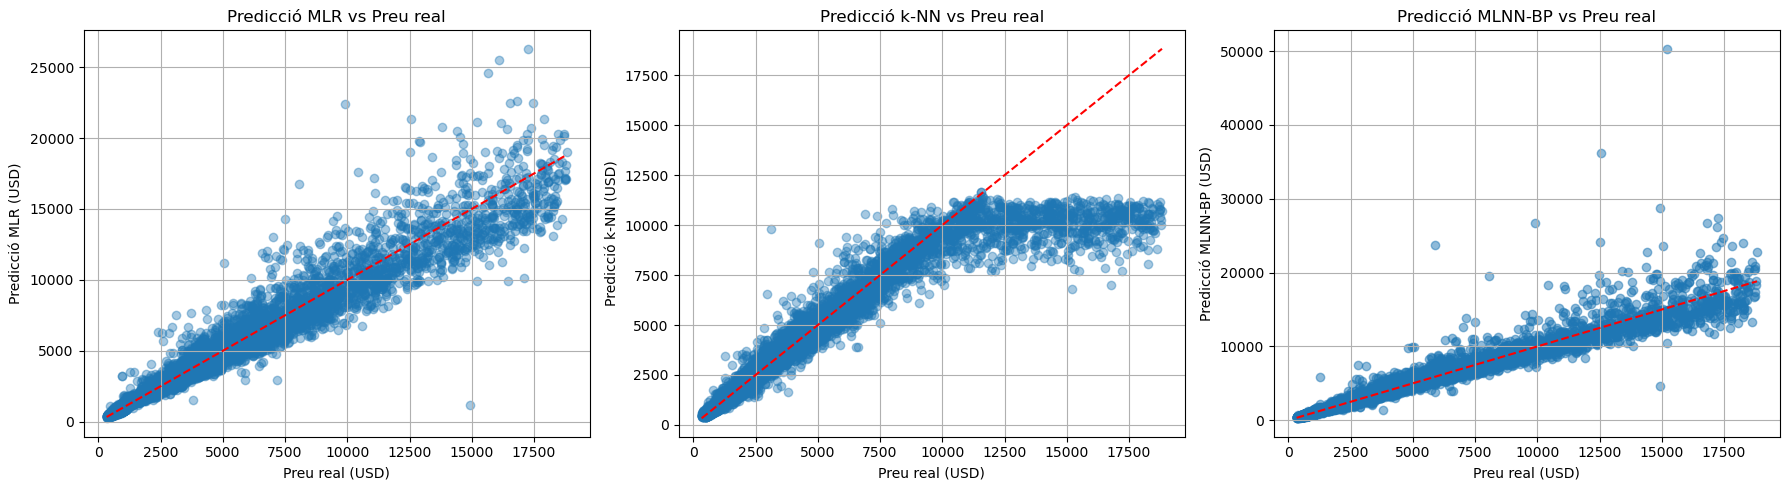

In [29]:
plt.figure(figsize=(18, 5))

# MLR
plt.subplot(1, 3, 1)
plt.scatter(df_results['price'], df_results['pred_price_mlr'], alpha=0.4)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció MLR (USD)')
plt.title('Predicció MLR vs Preu real')
plt.grid(True)

# KNN
plt.subplot(1, 3, 2)
plt.scatter(df_results['price'], df_results['pred_price_knn'], alpha=0.4)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció k-NN (USD)')
plt.title('Predicció k-NN vs Preu real')
plt.grid(True)

# MLNN-BP
plt.subplot(1, 3, 3)
plt.scatter(df_results['price'], df_results['pred_price_bp'], alpha=0.5)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció MLNN-BP (USD)')
plt.title('Predicció MLNN-BP vs Preu real')
plt.grid(True)

plt.tight_layout()
plt.show()

### Discisió i conclusions a partir dels resultats

**Resultats mètriques MAPE**

Els resultats de l'avaluació dels models utilitzant MAPE sobre l'avaluació inicial i la de test són els següents:

1. **MAPE MLR**: 0.11
2. **MAPE KNN**
    - MAPE validació per defecte: 0.13
    - MAPE optimització hiperparàmetres: 0.06
    - MAPE en el conjunt de test: 0.11
4. **MAPE MLP**
    - MAPE validació per defecte: 0.10
    - MAPE optimització hiperparàmetres: 0.052
    - MAPE en el conjunt de test: 0.0978

Podem observar que, després de l'optimització d'hiperparàmetres, la MLNN-BP és la que ofereix un millor MAPE, seguida molt de prop del model KNN. Aquesta diferència indica que els models més complexos poden captar millor la relació no lineal entre les variables. 

**DataFrame de comparació de preus reals VS Prediccions**

La taula de prediccions sobre el conjunt de test mostra que els 3 models es mantenen propers al preu real en la majoria dels casos, però també s'aprecien certs error per a valors alts de preu on el KNN sembla fer prediccions menys elevades.

**Scatter Plots**

- **MLR**: Presenta una bona alineació, tot i que hi ha certa dispersió als preus elevats.
- **k-NN**: Tendència a "aplanar" les prediccions per a preus alts, limitant-se a un rang estret de valors, fet que indica que no generalitza bé per als diamants més cars.
- **MLNN-BP**: Té més dispersió però sembla capturar millor la variabilitat en preus alts, encara que amb algún error puntual important.

**Conclusions**

És evident que hi ha alguns punts amb errors importants en presència d'outliers en el conjunt de test. Potser seria més adient tractar els outliers per l'entrenament dels models, ja que podrien haver aportat informació i sobre la complexitat real. Tot i això, no hem pogut provar de tractar-los per manca de temps. Per comprovar-ho, **treurem els outliers del conjunt de test en el següent apartat.**

En la comparació final dels 3 models, observem que:
- **MLR** ofereix una bona aproximació general, però mostra més dificultats en preus alts, on la seva dispersió és més gran.
- **k-NN**, després de l'optimització d'hiperparàmetres, millora significativament, però tendeix a "aplanar" les prediccions amb valors elevats.
- **MLNN-BP**: És el model que aconsegueix el millor rendiment global després de l'optimització, tot i que presenta errors puntuals per la presència d'outliers.

En conclusió, el model **MLNN-BP és la millor opció** per aquest problema, però seria interessant gestionar els outliers per millorar encara més la qualitat de les prediccions.

### Conjunt de test sense outliers

Treiem els outliers y tornem a seleccionar les variables.

In [30]:
df_test_cleaned = df_test_cleaned[~df_test_cleaned['id'].isin(outliers_test['id'])].copy()

X_test = df_test_cleaned.drop(columns=['id', 'price', 'log_price', 'high_price'])

#Variable dependent (target): el logaritme escalat del preu
Y_test = df_test_cleaned['log_price']

Tornem a fer les prediccions sobre el conjunt de test sense els outliers

In [31]:
#Prediccions sobre el conjunt de test
y_pred_mlr_scaled = best_mlr.predict(X_test)
y_pred_knn_scaled = best_knn.predict(X_test)
y_pred_mlp_scaled = best_mlp.predict(X_test)

#Desescalar prediccions
y_pred_mlr = desescalar_y(y_pred_mlr_scaled)
y_pred_knn = desescalar_y(y_pred_knn_scaled)
y_pred_mlp = desescalar_y(y_pred_mlp_scaled)
y_test_real = desescalar_y(Y_test)

# Crear DataFrame per comparar
comparison_df = pd.DataFrame({
    'preu_real': y_test_real,
    'pred_price_mlr': y_pred_mlr,
    'pred_price_knn': y_pred_knn,
    'pred_price_bp': y_pred_mlp
})

# Mostrar les primeres files
print(comparison_df.head(10).round(2))


# MAPE sobre preus reals
print(f"MAPE MLR (test): {mean_absolute_percentage_error(y_test_real, y_pred_mlr):.4f}")
print(f"MAPE KNN (test): {mean_absolute_percentage_error(y_test_real, y_pred_knn):.4f}")
print(f"MAPE MLP (test): {mean_absolute_percentage_error(y_test_real, y_pred_mlp):.4f}")

    preu_real  pred_price_mlr  pred_price_knn  pred_price_bp
0      8282.0         7278.45         8473.56        8003.20
1      2196.0         2333.07         2505.95        2335.99
3       760.0          763.56          821.74         750.05
4      1715.0         1737.53         1364.78        1536.55
7      4721.0         4366.28         4496.96        4509.64
8      1020.0          880.07          959.94         937.25
9       984.0          835.73          803.91         822.57
10     6487.0         6577.33         8007.08        6783.73
11     4398.0         4953.48         4612.80        4491.01
12      707.0          762.13          772.79         712.68
MAPE MLR (test): 0.1110
MAPE KNN (test): 0.0979
MAPE MLP (test): 0.0899


Assignem les variables especificades a l'enunciat

In [32]:
# Dataframe amb els atributs original més les prediccions
df_results = df_test_cleaned.copy()

# Desescalar les prediccions i assignar a les variables
df_results['pred_price_mlr'] = y_pred_mlr
df_results['pred_price_knn'] = y_pred_knn
df_results['pred_price_bp'] = y_pred_mlp

print("\nPrimeres files del dataframe amb les prediccions:")
display(df_results.head())


Primeres files del dataframe amb les prediccions:


,id,carat,cut,color,clarity,depth,table,x,y,z,price,log_price,high_price,pred_price_mlr,pred_price_knn,pred_price_bp
0,44001,1.031061,0.962204,-0.276568,1.136296,0.644537,-0.621747,0.493450,0.505095,-0.216885,8282,0.820138,1,7278.454259,8473.558386,8003.199286
1,44002,-0.022306,-0.999099,0.317021,-0.686214,-1.797116,1.360018,0.263464,0.286754,-0.403202,2196,0.524632,0,2333.073670,2505.954277,2335.985840
3,44004,-1.183711,0.962204,0.317021,2.351303,0.011516,-1.117188,-0.205240,-0.184862,-0.662300,760,0.288424,0,763.556991,821.744734,750.051288
4,44005,-0.454457,-0.018447,1.504197,-0.686214,0.463674,1.360018,0.109170,0.097525,-0.467249,1715,0.469597,0,1737.527607,1364.779253,1536.545488
7,44008,0.787976,0.962204,0.317021,-1.293718,0.825401,-0.126305,0.443959,0.458515,-0.243086,4721,0.695016,1,4366.284414,4496.955330,4509.637413


Mostrem les noves gràfiques

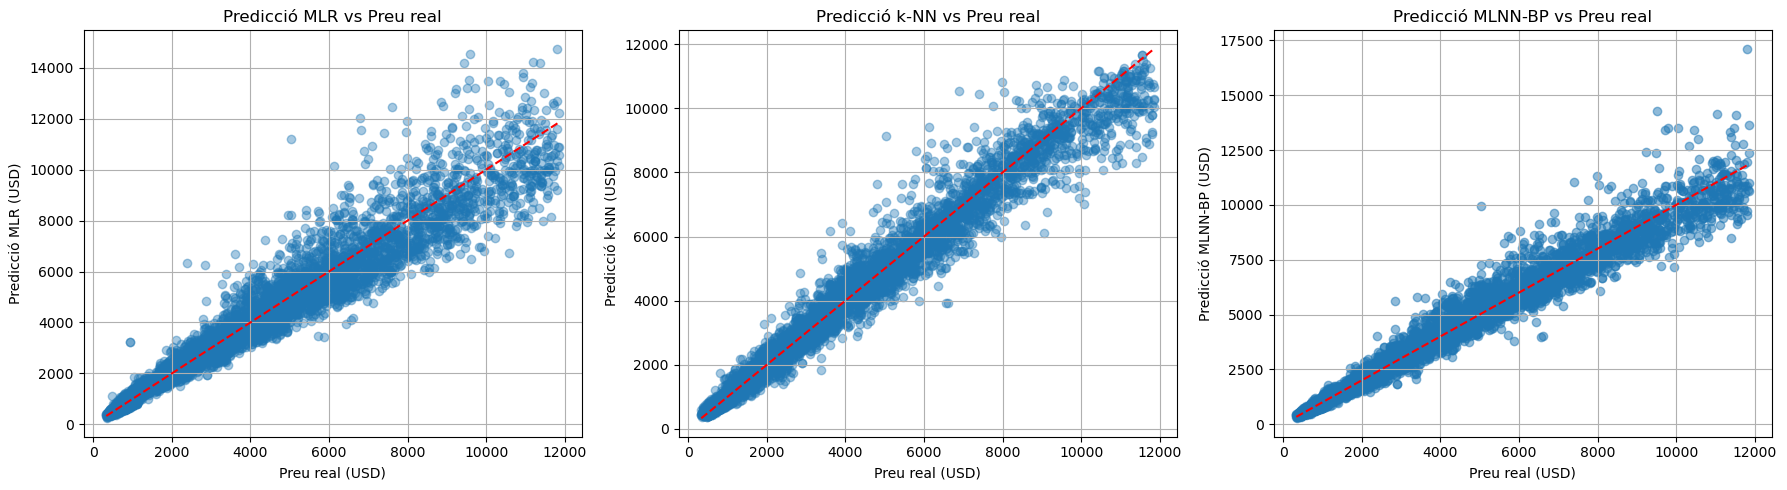

In [33]:
plt.figure(figsize=(18, 5))

# MLR
plt.subplot(1, 3, 1)
plt.scatter(df_results['price'], df_results['pred_price_mlr'], alpha=0.4)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció MLR (USD)')
plt.title('Predicció MLR vs Preu real')
plt.grid(True)

# KNN
plt.subplot(1, 3, 2)
plt.scatter(df_results['price'], df_results['pred_price_knn'], alpha=0.4)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció k-NN (USD)')
plt.title('Predicció k-NN vs Preu real')
plt.grid(True)

# MLNN-BP
plt.subplot(1, 3, 3)
plt.scatter(df_results['price'], df_results['pred_price_bp'], alpha=0.5)
plt.plot([df_results['price'].min(), df_results['price'].max()],
         [df_results['price'].min(), df_results['price'].max()],
         color='red', linestyle='--')
plt.xlabel('Preu real (USD)')
plt.ylabel('Predicció MLNN-BP (USD)')
plt.title('Predicció MLNN-BP vs Preu real')
plt.grid(True)

plt.tight_layout()
plt.show()

Si eliminem els outliers del conjunt de test, observem una millora general en resultats de tots els models. Els nous valors de MAPE són:

- MLR: 0.11
- KNN: 0.0979
- MLNN-BP: 0.089

Aquesta reducció, confirma que els outliers poden distorsionar significativament les prediccions. A més, les gràfiques de dispersió també mostren una **millor alineació** amb la línia perfecta de predicció, indicant una major precissió. Amb aquestes dades es consolida que el model **MLNN-BP és el que ofereix millor rendiment global**.

## 4. Classificació del preu

En aquest apartat es pretén desenvolupar un sistema de classificació capaç de predir si un producte té un preu alt o no. La variable objectiu és high_price, que pren valor **1 si el preu és superior a 2500$** i **0 en cas contrari**.

Per realitzar la tasca s'han utilitzat 3 mètodes diferents:

- **Logistic Regression (LR)**
- **Support Vector Machines (SVM)**
- **Multilayer Neural Network amb Back-Propagation (MLNN-BP)**

L'entrenament i l'ajust de hiperpàrametres de cada model s'ha fet amb cross-validation en el conjunt d'entrenament. Un cop optimitzats els models, s'han reentrenat amb el conjunt d'entrenament per ser aplicats sobre el conjunt de test.

Les mètriques d'avaluacio han sigut les següents:

- **Accuracy**: Proporció de classificacions correctes.
- **Sensitivity**: Capacitat del model per detectar els casos amb preu alt.
- **Specificity**: Capacitat del model per identificar correctament els casos amb preu baix.


**Apunt**: Com hem vist anteriorment, eliminarem també els outliers de test aquí.

### Selecció de variables i de la mètrica d'avaluació

Es defineixen les **variables independents (X)** i la **variable dependent (Y)** per al problema de classificació. 

També es defineix la funció `metriques_classificacio` per calcular les principals mètrqiues utilitzades en classificació binària. Aquest retorna la matriu de confusió, i les mètriques explicades anteriorment.

Es crea un diccionari de funcions de mètrica per a GridSearchCV pugui optimitzar el rendiment del model.

In [34]:
# Selecció de variables
X_train_class = df_train_cleaned.drop(columns=['id', 'price', 'log_price', 'high_price'])

df_test_cleaned = df_test_cleaned[~df_test_cleaned['id'].isin(outliers_test['id'])].copy()

X_test_class = df_test_cleaned.drop(columns=['id', 'price', 'log_price', 'high_price'])

Y_train_class = df_train_cleaned['high_price']
Y_test_class = df_test_cleaned['high_price']

#Funció per a les mètriques d'avaluació
def metriques_classificacio(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  
    specificity = tn / (tn + fp)
    return cm, accuracy, sensitivity, specificity

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

#Diccionari per la cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(specificity_score)
}

### Logistic Regression (LR)

Comencem per el model de regressió logístics per classificar si un diamant té un **preu alt (`high_price`= 1)** o no **(`high_price` = 0)**.

Primer s'entrena un primer model bàsic amb una partició del **80% per entrenament i 20% per validació**. Es calculen les mètriques establertes anteriorment.

In [35]:
#Prepara conjunt d'entrenament i validació 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_class, Y_train_class, test_size=0.2, random_state=42
)

#Entrenem el model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_split, y_train_split)

#Predicció
y_val_pred_lr = lr.predict(X_val_split)

#Avalució
cm_lr, acc_lr, sens_lr, spec_lr = metriques_classificacio(y_val_split, y_val_pred_lr)
print("Matriu de confusió (validació simple): \n", cm_lr)
print(f"Accuracy: {acc_lr:.4f}")
print(f"Sensitivity: {sens_lr:.4f}")
print(f"Specificity: {spec_lr:.4f}")

Matriu de confusió (validació simple): 
 [[4223   89]
 [  82 3357]]
Accuracy: 0.9779
Sensitivity: 0.9762
Specificity: 0.9794


Com que aquest model no té hiperparàmetres, entrenem el **model definitiu**.

In [36]:
best_lr = LogisticRegression(max_iter=1000)
best_lr.fit(X_train_class, Y_train_class)

LogisticRegression(max_iter=1000)

### Support Vector Machines (SVM)

En aquesta secció s'aplica un model de classificació SVM. S'utilitza una validació simple amb **80% del conjunt per entrenar i un 20% per validar**, a més de calcular les mètriques de rendiment especificades anteriorment.

In [37]:
#Preparem conjunt d'entrenamen i validació
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_class, Y_train_class, test_size=0.2, random_state=42
)

#Entrenem
svm_clf = SVC()
svm_clf.fit(X_train_split, y_train_split)

#Predicció
y_val_pred_svm = svm_clf.predict(X_val_split)

#Avaluació
cm_svm, acc_svm, sens_svm, spec_svm = metriques_classificacio(y_val_split, y_val_pred_svm)
print("Confusion matrix (validació simple SVM):\n", cm_svm)
print(f"Accuracy: {acc_svm:.4f}")
print(f"Sensitivity: {sens_svm:.4f}")
print(f"Specificity: {spec_svm:.4f}")

Confusion matrix (validació simple SVM):
 [[4225   87]
 [  67 3372]]
Accuracy: 0.9801
Sensitivity: 0.9805
Specificity: 0.9798


Apliquem una cerca en graella amb cross-validation (`GridSearchCV`) per trobar el millor valor del **paràmetre de regularització `C`**.

In [38]:
#Paràmetres
param_grid_svm = {
    'C': [0.1, 1, 10]
}

svm_base = SVC()
grid_svm = GridSearchCV(svm_base, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_svm.fit(X_train_class, Y_train_class)

print("Millors hiperparàmetres SVM:", grid_svm.best_params_)
print(f"Accuracy: {grid_svm.best_score_:.4f}")

Millors hiperparàmetres SVM: {'C': 10}
Accuracy: 0.9787


Fem una nova cerca per afinar el **hiperparàmetre `kernel`**, una funció que transforma les dades per fer-les separables en espais de dimensions més altes.

In [39]:
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
}

svm_base = SVC(C=10)
grid_svm = GridSearchCV(svm_base, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_svm.fit(X_train_class, Y_train_class)

print("Millors hiperparàmetres SVM:", grid_svm.best_params_)
print(f"Accuracy: {grid_svm.best_score_:.4f}")

Millors hiperparàmetres SVM: {'kernel': 'rbf'}
Accuracy: 0.9787


I per últim, afinem el **hiperparàmetre `gamma`**, que controla la influència d'un únic exemple de training.

In [40]:
param_grid_svm = {
    'gamma': ['scale', 'auto'],
}

svm_base = SVC(C=10, kernel='rbf')
grid_svm = GridSearchCV(svm_base, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_svm.fit(X_train_class, Y_train_class)

print("Millors hiperparàmetres SVM:", grid_svm.best_params_)
print(f"Accuracy: {grid_svm.best_score_:.4f}")

Millors hiperparàmetres SVM: {'gamma': 'scale'}
Accuracy: 0.9787


Un cop afinats els paràmetres, entrenem el **model definitiu**.

In [41]:
best_svm = SVC(C=10, kernel='rbf', gamma='scale')
best_svm.fit(X_train_class, Y_train_class)

SVC(C=10)

### Multilayer Neural Network amb Back-Propagation (MLNN-BP).

El tercer model aplicat ha estat una xarxa neuronal multicapa (MLP), entrenada mitjançant back-propagation. Aquesta xarxa és capaç de capturar relacions no lineals entre les variables, i pot arribar a obtenir resultats molt competitius si s'ajusta correctament.

Primer que tot entrenem un model **MLPClassifier** utilitzant una validació simple per fer una primera estimació del seu rendiment.

In [42]:
# Preparem un conjunt d'entrenament i un de validació
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_class, Y_train_class, test_size=0.2, random_state=42
)

#Entrenem
mlp = MLPClassifier()
mlp.fit(X_train_split, y_train_split)

#Predicció
y_val_pred_mlp = mlp.predict(X_val_split)

#Avaluació
cm_mlp, acc_mlp, sens_mlp, spec_mlp = metriques_classificacio(y_val_split, y_val_pred_mlp)
print("Confusion matrix (validació simple MLP):\n", cm_mlp)
print(f"Accuracy: {acc_mlp:.4f}")
print(f"Sensitivity: {sens_mlp:.4f}")
print(f"Specificity: {spec_mlp:.4f}")

Confusion matrix (validació simple MLP):
 [[4215   97]
 [  43 3396]]
Accuracy: 0.9819
Sensitivity: 0.9875
Specificity: 0.9775


Fem una cerca d'hiperparàmetres per millorar el rendiment del model. Comencem per cofiguracion de **l'estructura oculta** de la xarxa neuronal.

In [43]:
# Hidden_layer_sizes
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)]
}

grid = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_class, Y_train_class)
print("Millor hiperparàmetre:", grid.best_params_)
print(f"Accuracy: {grid.best_score_}")

Millor hiperparàmetre: {'hidden_layer_sizes': (50, 50)}
Accuracy: 0.9788660983328924


Després, afinem el **paràmetre de regularització `alpha`**, que controla la magnitud dels pesos per evitar overfitting.

In [44]:
#Alpha
param_grid = {
    'alpha': [0.0001, 0.001, 0.1]
}

grid = GridSearchCV(MLPClassifier(hidden_layer_sizes=(50,50)), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_class, Y_train_class)
print("Millor hiperparàmetre:", grid.best_params_)
print(f"Accuracy: {grid.best_score_}")

Millor hiperparàmetre: {'alpha': 0.1}
Accuracy: 0.9792015655557909


Ara afinem el `learning_rate`, on aquest pot ser `adaptive`, ajusta segons el rendiment, `constant`, taxa d'aprenentatge fixe.

In [45]:
#Learning_rate
param_grid = {
    'learning_rate': ['adaptive', 'constant']
}

grid = GridSearchCV(MLPClassifier(hidden_layer_sizes=(50,50), alpha=0.0001), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_class, Y_train_class)
print("Millor hiperparàmetre:", grid.best_params_)
print(f"Accuracy: {grid.best_score_}")

Millor hiperparàmetre: {'learning_rate': 'constant'}
Accuracy: 0.9795112190023882


Un cop afinats els hiperparàmetres, entrenem el **model definitiu**.

In [46]:
best_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', alpha=0.0001, learning_rate='adaptive', max_iter=1000, random_state=42)
best_mlp.fit(X_train_class, Y_train_class)

MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              max_iter=1000, random_state=42)

### Avaluació sobre el Conjunt de Test

Després d'ajustar els tres models s'han realitzat les prediccions sobre el conjunt de test. Per a cada model, s'han calculat les mètriques de **accuracy, sensitivity i specificity** mitjantçant la funció `metriques_classificacio`, que també genera la taula de confusió.

In [47]:
#Realitzem les prediccions i estimació de probabilitat en LR i MLNN-BP
y_pred_lr = best_lr.predict(X_test_class)
y_prob_lr = best_lr.predict_proba(X_test_class)[:, 1]

y_pred_svm = best_svm.predict(X_test_class)

y_pred_mlp = best_mlp.predict(X_test_class)
y_prob_mlp = best_mlp.predict_proba(X_test_class)[:, 1]

Per tal de facilitar la comparació entre models, es crea una **taula de confusió** amb les següents columnes:

- True Positives (TP)
- False Positives (FP)
- False Negatives (FN)
- True Negatives (TN)
- Accuracy
- Sensitivity
- Specificity

La taula final mostra la comparativa de les mètriques de cada model.

In [48]:
#Avaluació de cada model sobre el conjunt de test
cm_lr, acc_lr, sens_lr, spec_lr = metriques_classificacio(Y_test_class, y_pred_lr)
cm_svm, acc_svm, sens_svm, spec_svm = metriques_classificacio(Y_test_class, y_pred_svm)
cm_mlp, acc_mlp, sens_mlp, spec_mlp = metriques_classificacio(Y_test_class, y_pred_mlp)

#Creació del DataFrame
cm_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'MLNN-BP'],
    'True Positives (TP)': [cm_lr[1, 1], cm_svm[1, 1], cm_mlp[1, 1]],
    'False Positives (FP)': [cm_lr[0, 1], cm_svm[0, 1], cm_mlp[0, 1]],
    'False Negatives (FN)': [cm_lr[1, 0], cm_svm[1, 0], cm_mlp[1, 0]],
    'True Negatives (TN)': [cm_lr[0, 0], cm_svm[0, 0], cm_mlp[0, 0]],
    'Accuracy': [acc_lr, acc_svm, acc_mlp],
    'Sensitivity': [sens_lr, sens_svm, sens_mlp],
    'Specificity': [spec_lr, spec_svm, spec_mlp]
})

# Mostrar taules de confusió
print("Taula de Confusió i Mètriques:")
print(cm_df)

Taula de Confusió i Mètriques:
                 Model  True Positives (TP)  False Positives (FP)  \
0  Logistic Regression                 3725                   116   
1                  SVM                 3772                    99   
2              MLNN-BP                 3751                    73   

   False Negatives (FN)  True Negatives (TN)  Accuracy  Sensitivity  \
0                   123                 4786  0.972686     0.968035   
1                    76                 4803  0.980000     0.980249   
2                    97                 4829  0.980571     0.974792   

   Specificity  
0     0.976336  
1     0.979804  
2     0.985108  


Creem un **DataFrame final** que conté les classificacions i les probabilitats de pertànyer a la classe high_price per a cada model. Aquest dataframe inclou:

- Classificacions de cada model
- Probabilitats per als model de LR i MLNN-BP.

La taula resultant permet **comparar** directament les **prediccions i probabilitats** de cada model, facilitant la identificació de quins models tenen un rendiment superior.

In [49]:
df_test_class = df_test_cleaned.copy()

#Assignem les prediccions i probabilitats en variables especificades al l'enunciat
df_test_class['class_high_price_lr'] = y_pred_lr
df_test_class['class_high_price_svm'] = y_pred_svm
df_test_class['class_high_price_bp'] = y_pred_mlp
df_test_class['prob_high_price_lr'] = y_prob_lr
df_test_class['prob_high_price_bp'] = y_prob_mlp

print("\nDataFrame amb classificacions i probabilitats:")
print(df_test_class[['class_high_price_lr', 'class_high_price_svm', 'class_high_price_bp', 
                     'prob_high_price_lr', 'prob_high_price_bp']].head())


DataFrame amb classificacions i probabilitats:
   class_high_price_lr  class_high_price_svm  class_high_price_bp  \
0                    1                     1                    1   
1                    0                     0                    0   
3                    0                     0                    0   
4                    0                     0                    0   
7                    1                     1                    1   

   prob_high_price_lr  prob_high_price_bp  
0            1.000000        1.000000e+00  
1            0.208647        4.653243e-01  
3            0.000017        1.375339e-07  
4            0.004850        5.818761e-04  
7            0.999936        9.999244e-01  


Per avaluar la qualitat de la classificació dels models LR i MLNN-BP, es generen les **curves ROC** per comparar la taxa de falsos positius (FPR) amb la de certs positius (TPR).

A partir de les probabilitats predites, es van calcular les FPR i TPR per cada model mitjançant la funció `roc_curve`.

Aquesta informació es va utilitzat per traçar les curves ROC i calcular les **AUC (àrea sota la corba)**, que indiquen el rendiment general dels models en termes de classificació binària.

La línia discontínua negra indica el rendiment d'un model aleatori, i les corbes dels models mostren els seus rendiments respectius. Els valors AUC calculats per a cadascun dels models permeten una comparació directa entre ells.

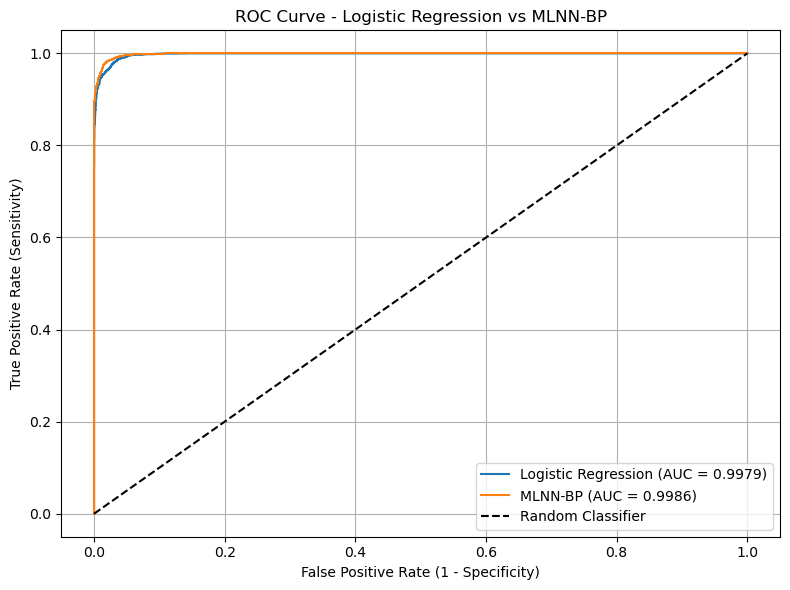

In [50]:
#Càlcul de la corba ROC per LR
fpr_lr, tpr_lr, _ = roc_curve(Y_test_class, y_prob_lr)
#Càlcul de l'AUC per LR
roc_auc_lr = auc(fpr_lr, tpr_lr)

#Càlcul de la corba ROC per MLNN-BP
fpr_mlp, tpr_mlp, _ = roc_curve(Y_test_class, y_prob_mlp)

#Càlcula de l'AUC per MLNN-BP
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Dibuixar les corbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLNN-BP (AUC = {roc_auc_mlp:.4f})')

# Referència diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Estètica
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Logistic Regression vs MLNN-BP')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussió sobre els resultats i conclusions

Després d'aplicar els 3 models de classificació sobre el conjunt de test, observem el següent:

Els resultats obtinguts mostren que els tes models ofereixen un rendiment molt alt tant en la validació com en el conjunt de test, amb **accuracies superiors al 97%**. En el conjunt de test veiem el següent:

- **LR**:
    - **Accuracy**: 0.9726
    - **Sensitivity**: 0.9680
    - **Specificity**: 0.9763
- **SVM**:
    - **Accuracy**: 0.9800
    - **Sensitivity**: 0.9802
    - **Specificity**: 0.9798
- **MLNN-BP**:
    - **Accuracy**: 0.9805
    - **Sensitivity**: 0.9747
    - **Specificity**: 0.9851

El model **MLNN-BP destaca com el més precís**, amb la millor combinació de sensitivity i specificity, fet que el fa més equilibrat en la detecció de positius com de negatius. **SVM** també mostra una gran capacitat de classificació, mentre que **LR**, manté un comportament molt competitiu.

A més, les àrees sota la **corba ROC (AUC)** indiquen una excel·lent capacitat de discriminació per part dels models, amb MLNN-BP obtenint el valor més alt **(AUC = 0.9986)**, lleugerament superior al **LR (AUC = 0.9979)**. Aquest petit avatatge consolida MLNN-BP com el model més robust i fiable per identificar correctament els casos de "preu alt" del conjunt de test.

Finalment, l'análisis de probabilitats predites demostra que els **MLNN-BP tendeix a assignar probabilitats més extremes i segures**. 

En conclusió el model **MLNN-BP és el model més adecuat** per aquest problema.
